# The program used TensorFlow 2 
1. Read data from txt file and transfer data by FFT.
2. Reduce length of data from 1024 to 100 point.
3. Training data by Tensorflow.

Load the TensorBoard notebook extension.

In [1]:
%load_ext tensorboard

Import function and set version of TensorFlow to 2.0:

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
from datetime import datetime
from numpy.linalg import inv, eig
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from packaging import version
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
import os
import tensorflow as tf
import itertools


print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.0.0-rc0


In [3]:
#Clear any logs from previous runs
!rm -rf ./logs/ 

##### Sub-function for read data from txt file and analyzed by FFT.

In [4]:
# Read data from 'fileName' in a number of text lines
def readDescriptionFile(fileName):
    error = None
    data = []
    try:
        # data = np.genfromtxt(fileName, delimiter=' ')
        file = open(fileName, "r")
        data = file.readlines()
    except Exception as e:
        error = "Cannot open description file!" + str(e)
    return data, error

# Read randomized frames from 'data' for a total number of 'nWindowNeeded'
# each frame has the size of 'nWinSize'
def selectWaveData(data,nWinSize,nMinWindows,nWindowNeeded):
    row = data.shape[0]
    nDataWin = row // nWinSize

    if nDataWin < nMinWindows:
        raise ValueError('Not enough window number')
    nBorderWindows = (nMinWindows-nWindowNeeded)//2
    np.random.seed(1)
    indices = np.random.permutation(nDataWin-(nBorderWindows*2) )
    indices2 = indices[0:nWindowNeeded]+nBorderWindows
    a = []
    for i in indices2:
        a = np.concatenate((a, data[i*nWinSize:(i+1)*nWinSize]))
    b = a.reshape((nWindowNeeded, nWinSize))
    return b

# Get sequential frame of data
def frameWaveData(data,nWinSize):
    row = data.shape[0]
    nDataWin = row // nWinSize

    a = data[0:(nDataWin * nWinSize)]
    b = a.reshape((nDataWin, nWinSize))
    return b

# Perform FFT on 'data'
def genArrayOfFFT(data):
    fftData = np.fft.fft(data)
    return np.absolute(fftData)

# Normalize 'data' by dividing by the magnitude of each data frame
def normalizeFFT(data):
    n, m = data.shape
    for i in range(0, n):
        data[i] = data[i] / (np.sqrt(np.inner(data[i], data[i])))
    return data

##### Sub-function for plot graph.

In [5]:
def plot_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    x = range(1, len(acc)+1)
    
    #Accuracy graph
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(x, acc)
    plt.title('Training accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

    #Loss graph
    plt.subplot(1,2,2)
    plt.plot(x,loss)
    plt.title('Training loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    #
    
    print(cm)
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.4f' if normalize else 'd'
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),horizontalalignment="center",color="white" if cm[i,j]>thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Set initial parameter of data:

In [6]:
# start_time = time.time()
nWindowNeeded = 120
nMinWindows  = 160
nWinSize = 2048
nWinSizeTest = 1024
nReducedFFTSize = 100
n_avg = 5

File name and path:

In [7]:
nAllWinSize = nWindowNeeded * nWinSize
reductionMatrixFile = 'reductionMatrix.npz'
reductionMatrixWavFile = './record/SoundTarget.txt'
dataFilePath = './record/'

Set initial for FFT:

In [8]:
allData = None
Sb = None
n_file = 0
s_min = 0
s_gap = 1
filter_weight = 4
reductionMatrix = np.load(reductionMatrixFile)['reductionMatrix']
dataFileName = dataFilePath + 'allData.npz'
labelsFileName = dataFilePath + 'labels.npz'
reductFileName = dataFilePath + 'reductionMatrix.npz'

Control loop:
1. Load new dataset.
2. Trainnig process.
3. Use old weight and bias parameter.
4. PCA method.
5. Testining data by using parameter from training process.

In [9]:
bFetchNewData = True      # Load new dataset
bTraining = True            # Training process
bUseOldWeight = False        # Use old weight&bias parameter
PCAmethod = True            # PCA method
LDAmethod = False
LDAmanual = False           # Use LDA method
TestProgramDP = True        # Test data by using parameter from deep learnnig

Loading new dataset

In [10]:
if bFetchNewData==True:
    #Read a list of file names
    fileList, error = readDescriptionFile(reductionMatrixWavFile)       
    if error is None:
        for fileInfo in fileList:
            parsedInfo = [str for str in fileInfo.split('\t')]  #extract data from each line
            fileNameInfo = [str for str in parsedInfo[0].split("\\")]   #extract file name
            fileName = dataFilePath + fileNameInfo[-1]
            try:
                rate, data = wavfile.read(fileName) #read all wave data
                data = frameWaveData(data,nWinSize) #put wave data into a number of frames
                n_file = n_file + 1  # number of file
            except Exception as e:
                print('Open wavefile:%s error! (%s)' % (fileName, str(e)))
                continue

            data = genArrayOfFFT(data)
            data = data[:, 0:nWinSizeTest]  # get important bands of the frequency data
            n = data.shape[0]

            #Find the average of spectrum from 'n_avg' data frames
            temp2 = None
            last_temp = data.mean(axis=0)
            last_temp = np.reshape(last_temp,[1,nWinSizeTest])
            cov_temp = np.cov(data.T)

            for i in range(n//n_avg):
                temp = data[(i*n_avg):((i+1)*n_avg)]
                temp = np.mean(temp,axis=0)
                temp = np.reshape(temp,[1,nWinSizeTest])

                temp = ((last_temp*filter_weight)+temp)/(filter_weight+1) #filter or average data
                last_temp = temp

                if temp2 is not None:
                    temp2 = np.concatenate((temp2,temp),axis=0)
                else:
                    temp2 = temp

            meanData = np.mean(temp2, axis=0)   #Average of data
            temp2 = normalizeFFT(temp2)     #Normalization data

            #Perform data & target into matrix
            result = np.ones((n//n_avg, 1)) * int(parsedInfo[1])  #Target data
            #data = np.concatenate((temp2, result), axis=1)  #Merge data & target to a matrix

            if allData is None:
                allData = temp2     #Input data
                labels = result     #Target data
                #meanDa = last_temp
                #meanAll = last_temp
                #covAll = cov_temp
                #sizeData = n
            else:
                allData = np.concatenate((allData, temp2), axis=0)       # All data
                labels = np.concatenate((labels, result), axis=0)
                #meanDa = np.concatenate((meanDa, last_temp), axis=0)    # Mean of each file
                #meanAll = meanAll + last_temp                           # Sum of mean all file
                #covAll = covAll + cov_temp                              # Covariance of all file
                #sizeData = np.append(sizeData, n)    # Mean of each file

                #plt.plot(data[0], 'ro')

    np.savez(dataFileName, allData=allData)  # save data to data file
    np.savez(labelsFileName, labels=labels)

#plt.show()

allData = np.load(dataFileName)['allData']      #load data from data file
labels = np.load(labelsFileName)['labels']
n, m = allData.shape
print('Load data ==> ok')
print(' ')

/Users/istru/anaconda3/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Open wavefile:./record/J101010_S_5_1.wav error! ([Errno 2] No such file or directory: './record/J101010_S_5_1.wav')
Load data ==> ok
 


## Deep Learning Algorithms

Set parameter for training process

In [11]:
# Parameter of training
max_iteration = 5  #Maximum iteration for main loop
min_mse = 1e-9     #Minimum mse, set default 1e-9
n_epochs = 1       #set the number of training epoch
batch_size = 32    #Batch size for training
learning_rate = 0.01  #Learning rate of Deep Learning, default 0.01
momen_tum = 0.8    #Momentum of training, default 0.9
iteration = 0      #Iteration for while loop
overall_mse_best = np.inf   #The best cost function
mse_best = np.inf           #Stop condition
mse_best_batch = np.inf     #The best cost function on batch

Set path for training model

In [12]:
checkpoint_path = "/tmp/my_dnn_model_scaler_sigmoid.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_dnn_model"     #Set the name of the trained model
previousStep_path = "/tmp/my_dnn_step_" #Set the template to generate file names for temporary models
best_model_path = "/tmp/my_dnn_step_"   #Set the template to generate file names for temporary models

### Training process

Train on 27399 samples
Epoch 1/10
27399/27399 - 2s - loss: 0.6057 - accuracy: 0.8267
Epoch 2/10
27399/27399 - 1s - loss: 0.1349 - accuracy: 0.9542
Epoch 3/10
27399/27399 - 1s - loss: 0.0776 - accuracy: 0.9754
Epoch 4/10
27399/27399 - 1s - loss: 0.0501 - accuracy: 0.9855
Epoch 5/10
27399/27399 - 1s - loss: 0.0360 - accuracy: 0.9897
Epoch 6/10
27399/27399 - 1s - loss: 0.0266 - accuracy: 0.9924
Epoch 7/10
27399/27399 - 1s - loss: 0.0209 - accuracy: 0.9942
Epoch 8/10
27399/27399 - 1s - loss: 0.0161 - accuracy: 0.9954
Epoch 9/10
27399/27399 - 1s - loss: 0.0135 - accuracy: 0.9966
Epoch 10/10
27399/27399 - 1s - loss: 0.0098 - accuracy: 0.9975
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./my_dnn_model/assets
27399/1 - 1s - loss: 0.0017 - accuracy: 0.9996
11743/1 - 0s - loss: 0.0040 - accuracy: 0.9987
Training accuracy: 99.9635
Testing accuracy: 99.8723


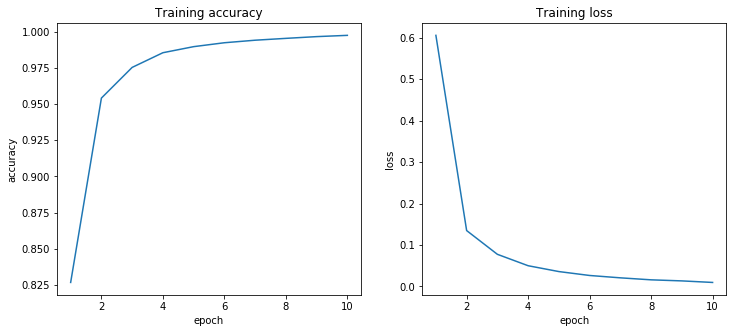

In [13]:
if bTraining==True:     # check if we need to perform training

    ##########################
    ### Prepare input data ###
    ##########################

#     #Random number of training & testing data
#     np.random.seed(0)
#     indices = np.random.permutation(n)

#     #Separate number of training data and testing data
#     n_trainData = int(n * 0.7)
#     n_testData = n - n_trainData

#     #Create training data set and test data set
#     trainData = allData[indices[0:n_trainData]]
#     testData = allData[indices[n_trainData:]]

#     #Training Input & Output
#     x_train = trainData[:, 0:(m - 1)]
#     y_train = trainData[:, m - 1]

#     #Testing Input & Output
#     x_test = testData[:, 0:(m - 1)]
#     y_test = testData[:, m - 1]
    
    x_train, x_test, y_train, y_test = train_test_split(allData, labels, test_size=0.3, random_state=100)

    #Save text file
    np.savetxt('x_train.txt', x_train)
    np.savetxt('y_train.txt', y_train)
    np.savetxt('x_test.txt', x_test)
    np.savetxt('y_test.txt', y_test)


    ##################
    ### PCA Method ###
    ##################
    if PCAmethod == True:
        x_train_mean = x_train.mean(axis=0)
        pca = PCA(n_components=100)
        #Training data
        x_train = pca.fit_transform(x_train)
        
        (m3, n3) = x_train.shape
        nReducedFFTSize = n3
        reductionMatrix = pca.components_.T[:, :n3]
        v = pca.explained_variance_ratio_
        
        #Calculate testing data
        x_test = x_test - x_train_mean
        x_test = x_test @ reductionMatrix

        #Save reduction matrix
        np.savez(reductFileName, reductionMatrix=reductionMatrix)

        #Save text file
        np.savetxt('A.txt', reductionMatrix)
        np.savetxt('InputTrain_A.txt', x_train)
        np.savetxt('InputTest_A.txt', x_test)


    #####################
    ### Deep Learning ###
    #####################
    
    #Define the Keras TensorBoard callback.
    logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    
    #Define the model.
    model = keras.models.Sequential([
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, activation='softmax')])

    #Train the model by adam.
#     model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=64, epochs=10, verbose=2, callbacks=[tensorboard_callback])

#     #Train the model by SGD.
#     sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#     model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])
#     model.fit(x_train, y_train, batch_size=64, epochs=10, callbacks=[tensorboard_callback])

    #Save model for mobile
    pretrained_model = tf.keras.applications.MobileNet()
    tf.saved_model.save(pretrained_model, final_model_path)
    
    #Evaluate model on training dataset
    lossTrain, accTrain = model.evaluate(x_train, y_train, verbose=2)
    lossTest, accTest = model.evaluate(x_test, y_test, verbose=2)
    print('Training accuracy: %.4f' %(accTrain*100))
    print('Testing accuracy: %.4f' %(accTest*100))
    
    #Plot history graph for accuracy and loss.
    plot_history(history)

TensorBoard for training process

In [14]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6007 (pid 5067), started 0:12:23 ago. (Use '!kill 5067' to kill it.)

### Testing process

Normalized confusion matrix
[[9.98865699e-01 2.26860254e-04 9.07441016e-04]
 [6.32511069e-04 9.96837445e-01 2.53004428e-03]
 [3.47584289e-04 5.21376434e-04 9.99131039e-01]]
11743/1 - 0s - loss: 0.0040 - accuracy: 0.9987


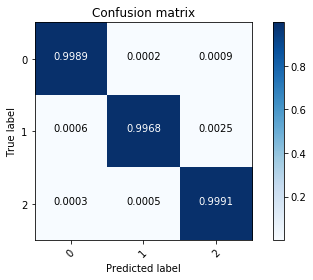

In [15]:
if TestProgramDP == True:
    #Predict labels of test data.
    y_predict = model.predict(x_test)
    y_pred = y_predict.argmax(axis=1)

    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm=cm,classes={0,1,2}, normalize = True)
    
    #Evaluate model on training dataset
    loss_pred, acc_pred = model.evaluate(x_test, y_test, verbose=2)

    imported = tf.saved_model.load(final_model_path)
    f = imported.signatures["serving_default"]